In [1]:
import nltk
import spacy

# Download WordNet data (if not already downloaded)
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
nlp = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kristian.nordby\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kristian.nordby\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Preprocessing function
def tokenize_and_lemmatize(df):
    """
    Processes a DataFrame by lemmatizing and tokenizing the 'Text' column
    and returns the DataFrame with an updated column containing the processed text.
    :param df: DataFrame with a 'Text' column.
    :return: DataFrame with a modified 'Text' column containing lemmatized and tokenized text.
    """
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    stop_words = nlp.Defaults.stop_words  # Default stop words from Spacy

    # Function to preprocess, tokenize, and lemmatize text
    def preprocess(text):
        tokens = text.split()
        # Lemmatize tokens and filter out stopwords
        processed_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
        # Join tokens back into a single string
        return ' '.join(processed_tokens)

    # Apply the preprocessing and tokenization function to the 'Text' column
    df['Text'] = df['Text'].fillna('').apply(preprocess)

    return df
# from google.colab import drive
# drive.mount('/content/drive')
df = pd.read_csv(r"C:\Users\kristian.nordby\OneDrive - West Point\Desktop\AY 25-1\NLP\Project 3\Reviews.csv")
df = tokenize_and_lemmatize(df)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought vitality canned dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanuts.....
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","confection centuries. light, pillowy citrus ge..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price. wide assortment yummy...


In [18]:
import pandas as pd

# Example DataFrame
# df = pd.DataFrame({'score': [5, 1, 2, 5, 3, 5, 4, 5, 1, 2, 3]})

# Count the occurrences of each score
score_counts = df['Score'].value_counts()

# Determine the minimum count (least common score)
min_count = score_counts.min()

# Sample equal number of rows for each score
balanced_df = (
    df.groupby('Score', group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
)

# Shuffle the rows to avoid any order bias (optional)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df.Score.value_counts())
targets_num = balanced_df['Score']
inputs_text = balanced_df['Text']
len(targets_num) == len(inputs_text)

Score
2    29769
1    29769
3    29769
5    29769
4    29769
Name: count, dtype: int64


C:\Users\kristian.nordby\AppData\Local\Temp\ipykernel_11436\855200190.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


True

In [19]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=.80, min_df=.05)

# Fit and transform the input text to create the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(inputs_text)

In [20]:
# Convert the reshaped array to a list (if needed)
inputs = tfidf_matrix

# Print the shape of the resulting vectors to confirm
print(f"Shape of input vectors: {inputs.shape}")

Shape of input vectors: (148845, 82)


In [21]:
from sklearn.preprocessing import OneHotEncoder
targets = np.array(targets_num).reshape(-1, 1)
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
targets = encoder.fit_transform(targets)

In [22]:
print(targets[1])

[1. 0. 0. 0. 0.]


In [23]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=.3)

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(82, 1)),  # Update input shape to (74, 1)
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 80, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 40, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 38, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 608)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        38,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,853 (167.39 KB)

 Trainable params: 42,853 (167.39 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs = 100, validation_data = (x_test, y_test))

Epoch 1/100
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.4167 - loss: 1.3587 - val_accuracy: 0.4012 - val_loss: 1.3989
Epoch 2/100
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accuracy: 0.4201 - loss: 1.3575 - val_accuracy: 0.4053 - val_loss: 1.3945
Epoch 3/100
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.4167 - loss: 1.3574 - val_accuracy: 0.4035 - val_loss: 1.3976
Epoch 4/100
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.4184 - loss: 1.3579 - val_accuracy: 0.4046 - val_loss: 1.3957
Epoch 5/100
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.4185 - loss: 1.3593 - val_accuracy: 0.4041 - val_loss: 1.3980
Epoch 6/100
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.4207 - loss: 1.3543 - val_accuracy: 0.4055 - val_loss: 1.3950
Epoch 7/100
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.4200 - loss: 1.3526 - val_accuracy: 0.4067 - val_loss: 1.3954
Epoch 8/100
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4191 

<Axes: >

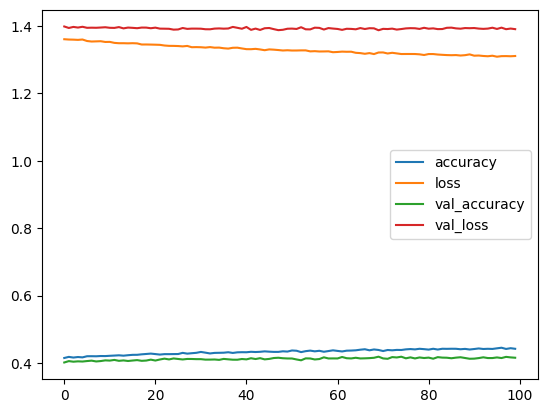

In [39]:
pd.DataFrame(history.history).plot()

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
y_test_predict = model.predict(x_test)
y_test_predict.shape

1396/1396 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


(44654, 5)

In [ ]:
y_true = np.argmax(y_test, axis=-1)         
y_pred = np.argmax(y_test_predict, axis=-1) 

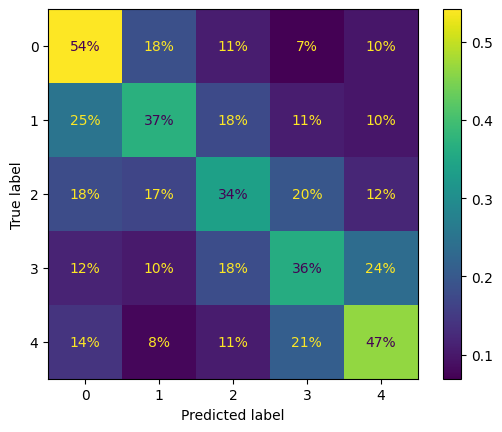

In [42]:
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis = -1),
                                       np.argmax(y_test_predict, axis = -1),
                                       normalize = 'true',
                                       values_format = '.0%')

In [49]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np

y_test_labels = np.argmax(y_test, axis=-1)
y_test_predict_labels = np.argmax(y_test_predict, axis=-1)

accuracy = accuracy_score(y_test_labels, y_test_predict_labels)
f1 = f1_score(y_test_labels, y_test_predict_labels, average='weighted') 
recall = recall_score(y_test_labels, y_test_predict_labels, average='weighted')
precision = precision_score(y_test_labels, y_test_predict_labels, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.415326734447082
F1 Score: 0.41250298576010663
Recall: 0.415326734447082
Precision: 0.4127013142088789


### Question 1: How effective is the CNN at performing multi-label classification on Amazon reviews?
The CNN was generally an inaccurate model. Overall, it yielded 41.5% accuracy on our test set, but its accuracy varied by classification category as shown by the confusion matrix above. On more extreme scores (1-star and 5-star reviews), it achieved 54% and 47% accuracy respectively. On more moderate scores (2,3, and 4 star ratings) it achieved only 34-37% accuracy. To achieve a highly accurate model, this model would have to be trained for a very long time (potentially over a day), but that would risk overfitting to the data and creating a model that is not very generalizable.

### Question2: What preprocessing steps improve CNN performance?
1. Changing `max_df` and `min_df` in our TFIDF Vectorization of each text was important in further distinguishing the texts. We also removed all stop words in this process.
2. We also removed many rows from the dataset in order to ensure that scores had an even distribution in the dataset. Above, we removed rows until all scores appeared at a maximum of roughly 30,000 times because that is the amount of times our least common score appeared. Therefore, we ensured that all scores appeared at an equal frequency such that the model would not learn to always classify a comment as the most common rating to achieve higher accuracy.

### Question 3: . Do different CNN kernel sizes and pooling methods enhance pattern recognition in product categories?
Yes, smaller kernel sizes are typically used to capture more complex and smaller details in the training data, while larger kernel sizes may be used to capture broader patterns in the data. In this case, we used a smaller kernel size of 3 in order to better capture the connection between words and sentence structure. This makes sense because sentences may have a sarcastic tone, indicating poorer reviews, or use more complicated word choices that alter the meaning the of the sentence. For our pooling method, we used Max Pooling. Max Pooling can allow for recognition of more dominant features in the data, which in our case is stronger word choice, which we believe to be the best indicators of the sentimenet of the review.

### Question 4: Which categories are challenging to classify, and why?
The more moderate scores, 2-4 star ratings, were the most challenging to classify and had the lowest accuracy scores. This is because they likely do use less extreme words that allow the model to more easily classify the review as either good or bad. In other cases, these reviews may mention something terrible about the business, but then move on to concede the business also did something great, which could confuse the model.

### Question 5: How does the CNN compare to baseline models like Logistic Regression for multi-label classification?
CNN is much easier to use because it can more easily extract features as it fits to the training data, while a logistic regression model works better on lower-dimension data in which it can determine *linear* relationships. For this reason, CNNs are typically more accurate on high-dimensional data such as pictures and NLP tasks because it can better capture high-level complex patterns, while logistic regression models may be better used for small, structured datasets with linear patterns.